# WDSS Football Forecasting Competition





<img src="logo_subtitle.png" width=500 />

## Our Sponsor

<img src="mustard-systems-logo.png" width=500 />

## The Competition

- Predicting the scores of football matches isn't a new idea 


- People try their luck at bookies daily with nothing more than guesses, however at WDSS a more data-driven approach is preferred 

- The competition aims to draw together the best implementations of these with hopes of finding the best model possible

## The Format

- Weekly predictions on the **scores** of each Premier League match, starting Week 2


- Each week the predictions must be **ranked** from 1 to 10 in terms of confidence

- Each contestor's predictions will be scored based on their weighted **mean squared error** and converted into points using a monotonously-decreasing rule 

## The Calendar

|Warwick Week| Week Starting|GW   | Game Days   |Fixtures|
|------------|--------------|-----|----------   |--------|
|Week 2      |11 - Oct      |8    |Sat - Mon    |10      |
|Week 3      |18 - Oct      |9    |Fri - Sun    |10      |
|Week 4      |25 - Oct      |10   |Sat - Mon    |10      |
|Week 5      |01 - Nov      |11   |Fri - Sun    |10      |
|Week 6      |08 - Nov      |BREAK|BREAK        |-       |
|Week 7      |15 - Nov      |12   |Sat - Sun    |10      |
|Week 8      |22 - Nov      |13   |Sat - Sun    |10      |
|Week 9      |29 - Nov      |14&15|Tue, Wed, Sat|10      |
|Week 10     |06 - Dec      |16   |Sat          |10      |

## The Rules

- All weekly submissions must be accompanied by a model created in **Jupyter Notebooks (.ipynb file)** or **R Markdown notebooks (.Rmd)**

- Scores predicted must **match the output of your model** (we will check this and disqualify inconsistent submissions) 



- Sources of data should be made clear within submissions

- There will be some flexibility in what constitutes as a model, but please refer to today's demo model as a benchmark 



- Have Fun! 

## The Winner & Prize

- The competition will be split across Term 1 & 2 with a **prize pool of £700** for each iteration 


- This prize pool will be split between the top competitors as ranked by the accuracy of their predictions 


- Additionally, a £100 prize will be awarded for the model that displays the most **ingenuity**, **creativity**, and **good statistical practice** 

# Getting Started: lets build a demo model

- Today we will guide you in building a **baseline model** for our upcoming Premier League forecasting competition

- This model will NOT win the competition for you, but it will help point you in the right direction

## Start out with our imports

In [24]:
# Dependencies
from scipy.stats import poisson 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Gathering our data

In [2]:
# Function to retrieve premier league data
def get_premier_league_data(start_year):
    season = str(start_year)[-2:] + str(start_year + 1)[-2:]
    data = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + season + "/E0.csv") 
    return data

In [3]:
# Get data from the 2018/2019 season
data = get_premier_league_data(2018)
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


## Light cleaning

In [4]:
# Filtering columns of interest
columns = ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]
data = data[columns]

# Renaming columns
data = data.rename(
    columns={"FTHG": "HomeGoals", "FTAG": "AwayGoals", "FTR": "Result"}
)

In [5]:
# Remove final week of fixtures

In [6]:
data.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Man United,Leicester,2,1,H
1,Bournemouth,Cardiff,2,0,H
2,Fulham,Crystal Palace,0,2,A
3,Huddersfield,Chelsea,0,3,A
4,Newcastle,Tottenham,1,2,A


## Simple analysis: Home team advantage?


In [7]:
# Compute the average number of home and away goals 

HomeGoals    1.575676
AwayGoals    1.224324
dtype: float64

## Towards a match prediction model 

- One way to predict the match score is to consider the number of goals scored by each team


- We will denote the number of goals scored by a particular team in a match $i$ by $y_i$ 


- Furthermore, we will use *regression analysis* to model $\mathbb{E}[y | \boldsymbol{x}_i]$, where $\boldsymbol{x}_i$ is a vector of $k$ predictor variables for one particular match

## The Poisson distribution

- The Poisson distribution is often used to model the probability distribution of *count events* (that is, the same event happening a specific number of times in a fixed time frame)


- It is a *discrete* distribution parametarized by a mean constant rate of occurences $\lambda$

- It assumes that event occurances within the interval are *independent* of one another

- It can be especially useful to model the number of goals we expect a team to score

## The Poisson distribution: an example

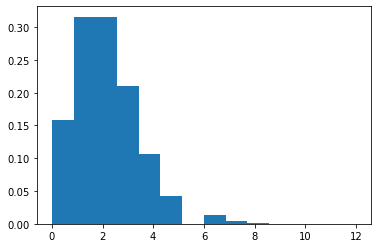

In [8]:
# Here we simulate 1 million samples from a Poisson distribution with a mean of two
x = np.random.poisson(2, 1000000)
plt.hist(x, 14, density=True)
plt.show()

## Preparing our training data

In [9]:
# Separate home goals data
home_goals = data[["HomeTeam", "AwayTeam", "HomeGoals"]]
home_goals = home_goals.assign(home=1)
home_goals = home_goals.rename(
    columns={"HomeTeam": "team",
             "AwayTeam": "opponent", 
             "HomeGoals": "goals"}
)

# Separate away goals data

In [10]:
# Concatenating into training data 
train_data = pd.concat([home_goals, away_goals])
train_data.head()

,team,opponent,goals,home
0,Man United,Leicester,2,1
1,Bournemouth,Cardiff,2,1
2,Fulham,Crystal Palace,0,1
3,Huddersfield,Chelsea,0,1
4,Newcastle,Tottenham,1,1


## The Poisson regression model

- To predict the number of goals each team scores, we will fit the following model using match-level data


$$y_i \sim Poisson(\lambda_i)$$


$$\ln (\lambda_i) = \beta_0 \,+\, \beta_1x_{i1} + ... + \beta_1x_{ik}$$

- Here, $\lambda_i$ is the mean number goals scored by the home team in match $i$, which we aim to predict using variables $\boldsymbol{x}_i$

In [11]:
# Building the model
# Poisson Regression: log-linear model
poisson_model = smf.glm(
    formula="goals ~ ???",
    data=train_data,
    family=sm.families.Poisson() 
).fit()

In [12]:
# Get a statistical summary of the poisson model
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1105.9
Date:                Sat, 02 Oct 2021   Deviance:                       883.94
Time:                        12:08:59   Pearson chi2:                     754.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5195      0.189      2.747      0.006       0.149       0.890
team[T.Bournemouth]           -0.0536      0.189     -0.284      0.776      -0.423       0.316
team[T.Brighton]              -0.2940      0.203     -1.448      0.148      -0.692       0.104
team[T.Burnley]               -0.0501      0.191     -0.262      0.793      -0.425       0.325
team[T.Cardiff]               -0.0039      0.185     -0.021      0.983      -0.367       0.359
team[T.Chelsea]               -0.1413      0.192     -0.735      0.463      -0.518       0.236
team[T.Crystal Palace]        -0.4714      0.216     -2.177      0.029      -0.896      -0.047
team[T.Everton]               -0.1474      0.192     -0.767      0.443      -0.524       0.229
team[T.Fulham]                -0.0407      0.190     -0.215      0.830      -0.412       0.331
team[T.Huddersfield]          -0.3552      0.204     -1.738      0.082      -0.756       0.045
team[T.Leicester]             -0.2332      0.200     -1.164      0.245      -0.626       0.160
team[T.Liverpool]              0.1084      0.182      0.594      0.553      -0.249       0.466
team[T.Man City]               0.1545      0.178      0.866      0.387      -0.195       0.504
team[T.Man United]             0.0061      0.188      0.033      0.974      -0.362       0.374
team[T.Newcastle]             -0.1954      0.194     -1.006      0.315      -0.576       0.185
team[T.Southampton]           -0.0070      0.189     -0.037      0.971      -0.377       0.363
team[T.Tottenham]             -0.1941      0.198     -0.981      0.327      -0.582       0.194
team[T.Watford]               -0.1313      0.195     -0.675      0.500      -0.513       0.250
team[T.West Ham]              -0.0032      0.185     -0.017      0.986      -0.366       0.360
team[T.Wolves]                -0.1898      0.194     -0.977      0.329      -0.571       0.191
opponent[T.Bournemouth]       -0.0072      0.180     -0.040      0.968      -0.359       0.345
opponent[T.Brighton]          -0.3280      0.193     -1.702      0.089      -0.706       0.050
opponent[T.Burnley]           -0.1443      0.184     -0.785      0.432      -0.504       0.216
opponent[T.Cardiff]           -0.3863      0.201     -1.926      0.054      -0.779       0.007
opponent[T.Chelsea]           -0.2132      0.190     -1.124      0.261      -0.585       0.159
opponent[T.Crystal Palace]    -0.0791      0.180     -0.439      0.661      -0.432       0.274
opponent[T.Everton]           -0.3367      0.196     -1.714      0.087      -0.722       0.048
opponent[T.Fulham]            -0.1437      0.184     -0.781      0.435      -0.504       0.217
opponent[T.Huddersfield]      -0.1356      0.186     -0.730      0.466      -0.500       0.229
opponent[T.Leicester]         -0.1892      

## A note on dummies, coefficients, and interpretation

- $Team_i$ takes on multiple categorical values (Chealsea, Man City, etc.) but statistical algorithms can't process string data *directly* 

- **Solution:** We encode categorical variables into *dummy* or *indicator variables*

- Eg. $Man City_i = \begin{cases} 
      1 & Team_i = \text{'Man City'} \\ 
      0 & \text{otherwise} 
   \end{cases} $ 

- As for the coefficients? they represent the *approximate* fractional change in average goals for a unit change in the predictor variables 

- For coefficients on dummy variables, this change is always **relative to the category combination represented by the intercept**

## Predicting the expected goals for each team

In [13]:
# Create feature data for home and away team for the match
def create_X(home_team, away_team):
    X_home = pd.DataFrame(data={"team": home_team,
                                "opponent": away_team,
                                "home": 1
                                }, index=[1])
    
    # Creating DataFrame for away team features 
    X_away = pd.DataFrame(data={"team": away_team,
                                "opponent": home_team,
                                "home": 0
                                }, index=[1])
    return X_home, X_away

In [14]:
def predict_avg_goals(X_home, X_away, model):
    # Predict the mean number of goals for home team
    home_goals_avg = model.predict(X_home) 
    
    # Predict the mean number of goals for away team
    away_goals_avg = model.predict(X_away) 
    
    return home_goals_avg, away_goals_avg

In [15]:
# Predicting average goals for Chelsea Man City match
X_home, X_away =  create_X('Chelsea', 'Man City')
avg_goals = predict_avg_goals(X_home, X_away, poisson_model)
print('Average Home Goals: ', avg_goals[0].values[0])

# Fill in to print the average away goals
print('Average Away Goals: ', avg_goals[1].values[0])

Average Home Goals:  1.3300297305877133
Average Away Goals:  1.5853735447243837


## Computing the distribution of match scores

In [16]:
# Funciton to forecast a given match
# Probability Mass Function
def predict_score_pmf(X_home, X_away, model, max_goals):
    
    # Predict the average number of goals for home  and away teams
    home_goals_avg, away_goals_avg = predict_avg_goals(X_home, X_away, model)

    # Compute marginal distribution for home goals
    home_goals_pmf = [poisson.pmf(i, home_goals_avg)
                      for i in range(0, max_goals + 1)]

    # Compute marginal distribution for away goals
    
    # Compute joint distribution for match score as outer product
    joint_pmf = np.outer(np.array(home_goals_pmf),
                         np.array(away_goals_pmf))
    
    return joint_pmf

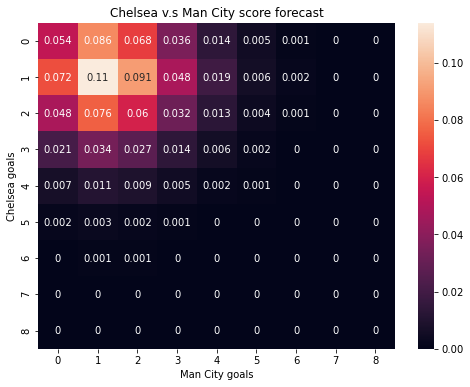

In [17]:
# Predicting distribution of match scores
X_home, X_away =  create_X('Chelsea', 'Man City')
score_pmf = predict_score_pmf(X_home, X_away, poisson_model, 8)
score_pmf = score_pmf.round(3)

# Visualizing distribution in a heatmap
f, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(score_pmf, annot=True)
axs.xaxis.tick_top() # x axis on top
axs.xaxis.set_label_position('top')
plt.title("Chelsea v.s Man City score forecast", y=1.12)
plt.xlabel("Man City goals", labelpad=6)
plt.ylabel("Chelsea goals")
plt.show()

## Forecasting the match score

In [18]:
def predict_score(X_home, X_away, model):
    # Predicting distribution of match scores
    score_pmf = predict_score_pmf(X_home, X_away, model,16)
    score_pmf = score_pmf.round(3)
    
    # Computing distribution mode
    home_goals_mode = np.argmax(score_pmf) // (17)
    away_goals_mode = np.argmax(score_pmf) % (17)
    score_pred = (home_goals_mode, away_goals_mode)
    return score_pred

In [19]:
# Predicting Chelsea Man City match score
X_home, X_away =  create_X('Chelsea', 'Man City')
score_pred =  predict_score(X_home, X_away, poisson_model)
print('Score Forecast: ', score_pred)

Score Forecast:  (1, 1)


## Validating our predictions ... how well did we do?

- To find out how our model performed, it is important to devise some form of scoring metric


- In this workshop, we will use the mean squared error to asses this:
$$\text{MSE}(y, \hat y) \,=\, \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat y_i)^2$$

In [20]:
def mse(y_true, ypred):
    np.square(np.subtract(Y_true,Y_pred)).mean()

In [21]:
def model_eval(X, model):
    # Predicting distribution of match scores
    #### LEFT AS AN EXERCISE ####
    pass

## Links to some data sources


Future Fixtures CSV: https://fixturedownload.com/download/epl-2021-GMTStandardTime.csv


Historical Standings: https://www.rotowire.com/soccer/league-table.php?season=2018

## Next Steps

- Sign up and Participate in the competition!

- Build on the benchmark


- Additional regressors (betting odds?)

- Alternative data sources (Twitter and NLP?)

- Cross-validation of predictions


- Dixon-Coles model


# How to sign up for the competition?